In [1]:
import seapy
import Obs_workspace as ow
import numpy as np

NumExpr defaulting to 8 threads.


In [3]:
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24
grid = seapy.model.asgrid(grdfile)

In [16]:
Datasets = [
            'NSFC2012SPRING-YS',
            'NSFC2012SPRING-ES',
            'IOCAS2012SPRING',
            'NSFC2012AUTUMN-ES',
            'IOCAS2012AUTUMN',
            'NSFC2013SPRING-CJ',
            'IOCAS2013SPRING'
           ]


In [33]:
obss = []

In [34]:
# loading sst obs
sst_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/NOAA_GHRSST/geopolar_sst_2012.nc')

In [35]:
for dataset in Datasets:
    print(dataset)
    thisdataset = ow.insitu_workspace('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS',dataset,dataset)
    thisdataset.pull_ctdinfos()
    # must pull_ctdinfos before pull_alldata
    if dataset =='NSFC2012SPRING-YS':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['H03','H16','H25','H34'],'TEMP':[]})
    elif dataset == 'NSFC2012SPRING-ES':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':[],'TEMP':[]})
    elif dataset == 'IOCAS2012SPRING':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3800-01','3800-02','B-03','DH6-2'],'TEMP':['DH6-2',]})
    elif dataset == 'NSFC2012AUTUMN-ES':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':[],'TEMP':[]})
    elif dataset == 'IOCAS2012AUTUMN':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3500-09',],'TEMP':['3500-09','DH4-1']})
    elif dataset == 'NSFC2013SPRING-CJ':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['A01-03','A01-09','A02-04','A02-08','A03-06','A03-09','A04-07','A06-05','A13-01'],'TEMP':['A04-07',]})
    elif dataset == 'IOCAS2013SPRING':
        thisdataset.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3600-05','3800-04',],'TEMP':[]})
    thisdata = [seapy.roms.obs.raw_data("TEMP", "CTD", thisdataset.data['TEMP'].value_r,None,0.1),
                seapy.roms.obs.raw_data("SALT", "CTD", thisdataset.data['PSAL2'].value_r,None,0.01),]
    thisinsitu_obs = seapy.roms.obs.gridder_ctd(grid,thisdataset.data['TEMP'].time_r,
                                                thisdataset.data['TEMP'].lon_r,thisdataset.data['TEMP'].lat_r,-thisdataset.data['TEMP'].depth_r, 
                                                thisdata,dt,title="cruise CTD observation %s"%(dataset))
    obss.append(thisinsitu_obs)
    sst_obs.add(thisinsitu_obs)

NSFC2012SPRING-YS
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS
PSAL2
qc specified: 
['H03', 'H16', 'H25', 'H34']
quality control is activate: H03
quality control is activate: H16
quality control is activate: H25
quality control is activate: H34
TEMP


Output()

NSFC2012SPRING-ES
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-ES
PSAL2
TEMP


Output()

IOCAS2012SPRING
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012SPRING
PSAL2
qc specified: 
['3800-01', '3800-02', 'B-03', 'DH6-2']
quality control is activate: 3800-01
quality control is activate: 3800-02
quality control is activate: B-03
quality control is activate: DH6-2
TEMP
qc specified: 
['DH6-2']
quality control is activate: DH6-2


Output()

NSFC2012AUTUMN-ES
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012AUTUMN-ES
PSAL2
TEMP


Output()

IOCAS2012AUTUMN
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN
PSAL2
qc specified: 
['3500-09']
quality control is activate: 3500-09
TEMP
qc specified: 
['3500-09', 'DH4-1']
quality control is activate: 3500-09
quality control is activate: DH4-1


Output()

NSFC2013SPRING-CJ
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2013SPRING-CJ
PSAL2
qc specified: 
['A01-03', 'A01-09', 'A02-04', 'A02-08', 'A03-06', 'A03-09', 'A04-07', 'A06-05', 'A13-01']
quality control is activate: A01-03
quality control is activate: A01-09
quality control is activate: A02-04
quality control is activate: A02-08
quality control is activate: A03-06
quality control is activate: A03-09
quality control is activate: A04-07
quality control is activate: A06-05
quality control is activate: A13-01
TEMP
qc specified: 
['A04-07']
quality control is activate: A04-07


Output()

IOCAS2013SPRING
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2013SPRING
PSAL2
qc specified: 
['3600-05', '3800-04']
quality control is activate: 3600-05
quality control is activate: 3800-04
TEMP


Output()

In [36]:

sst_obs.to_netcdf('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/combined_obs_2012.nc')


In [51]:
withcruise_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/combined_obs_2012.nc')

In [56]:
plt.plot(withcruise_obs.[withcruise_obs.type==7])

SyntaxError: invalid syntax (3037749351.py, line 1)

In [9]:
np.min(thisinsitu_obs.error[thisinsitu_obs.type==6])

0.010000000000000002

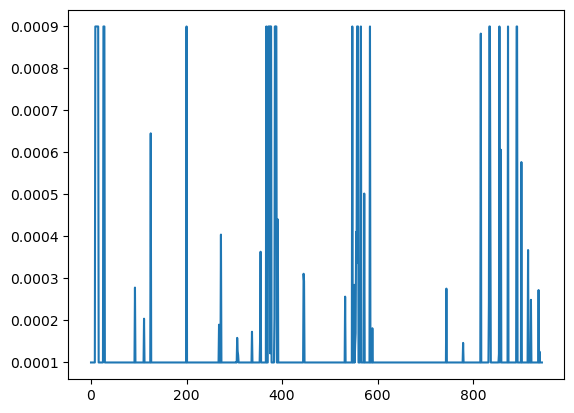

In [50]:
import matplotlib.pyplot as plt
ind = 6
plt.plot(obss[ind].error[obss[ind].type==7])

In [12]:
thisdataset.data['PSAL2'].value_r.shape

(107000,)

In [ ]:
!!!!!!!!!!!!!!!!!!!!!!CHANGE the refine level!!!!!!!!!!!!!!!!!!!!!